# ALeRCE LSST, python client queries

```Author: Alejandra Muñoz Arancibia. Last updated: 260224```

This notebook shows how to query the Rubin alert stream data (as well as derived properties) stored by the ALeRCE broker. We show examples of queries to our database tables and alert image cutouts (hereafter "stamps") via the ALeRCE python client, using the pandas package to manipulate output tables as dataframes.

We refer to [this notebook](https://github.com/alercebroker/usecases/tree/master/notebooks/LSST/ALeRCE_LSST_Tables.ipynb) for a detailed description of how Rubin data are stored in the ALeRCE multistream database. Advanced queries not yet available for the python client can be done using Astronomical Data Query Language (ADQL) queries to the ALeRCE Table Access Protocol (TAP) service, as described in detail in [this notebook](https://github.com/alercebroker/usecases/tree/master/notebooks/LSST/ALeRCE_LSST_TAP_Queries.ipynb).

### Some settings

Install the [ALeRCE python client](https://alerce.readthedocs.io/en/latest/) uncommenting the following line. In case you have a previous alerce package version, note that you need to update it to the latest one to retrieve Rubin data.

In [1]:
#!pip install alerce

Load libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18
from astropy.time import Time
import sys

In [3]:
from IPython.core.display import HTML
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)

In [4]:
from alerce.core import Alerce

## Initialize the ALeRCE client

In [5]:
alerce_client = Alerce()

### LSST queries to the ALeRCE multisurvey database

We save Rubin alert stream data in a multisurvey database. We distinguish among data sources by using the field ```tid```, for "telescope identifier". LSST (and more generally, all Rubin data observed with the Simonyi telescope) has ```tid = 1```.

In [6]:
tid = 1

### Rubin identifiers

In LSST alerts, astrophysical objects have different identifiers depending on what they are associated to. Non-moving objects (e.g. supernovae, active galactic nuclei, variable stars) are associated to diaObjects, while known Solar System moving objects (e.g. asteroids) are associated to ssObjects. Identifiers for diaObjects and ssObjects are generated independent of each other by the lsst pipelines. We distinguish among them using the field ```sid```, for "survey identifier".

We use the field ```oid``` as the identifier for each object. This ```oid``` is defined in different ways depending on the availability of diaObject information in the alert, so that

```oid = diaObjectId``` and ```sid = 1``` for objects that have diaObject information, and

```oid = ssObjectId``` and ```sid = 2``` if they only have ssObject information. In case an object has both identifiers (e.g. a known Solar System object was identified at a small angular distance from a non-moving object), we adopt ```oid = diaObjectId``` and ```sid = 1``` while still saving both their diaObject and ssObject data in the respective tables.

We call the identifier for each epoch in every survey as ```measurement_id```. For LSST, this means both field ```diaSourceId``` for detections and field ```diaForcedSourceId``` for forced photometry points are renamed ```measurement_id``` in our database.

## How to query individual objects

Here we illustrate two examples of object queries: 1) a diaObject, and 2) a cone search. The first case is useful when the object identifier is known, while the second is useful to explore LSST data for an object from an external catalog whose equatorial coordinates are known. A third case, 3) a ssObject, is covered by TAP queries in [this notebook](https://github.com/alercebroker/usecases/tree/master/notebooks/LSST/ALeRCE_LSST_TAP_Queries.ipynb). Along these examples we show how to query several properties, like basic statistics, light curves, and stamps.

### Query a diaObject

We choose ```oid = diaObjectId = 313853496686280764```, which can be found in the ALeRCE LSST Explorer as https://lsst.alerce.online/object/313853496686280764?survey=lsst. This object was reported to the [Transient Name Server](https://www.wis-tns.org/) based on ATLAS detections ([Tonry et al. 2025](https://www.wis-tns.org/object/2025agtf/discovery-cert)) and received the name [AT 2025agtf](https://www.wis-tns.org/object/2025agtf). According to NED, its tentative host (WISEA J003724.47-422751.5) has a redshift $z = 0.070493$.

In [7]:
oid = 313853496686280764
sid = 1
z_obj = 0.070493

#### Basic statistics

We query the main properties of this object as

In [8]:
df_obj = alerce_client.query_object(oid=oid, survey='lsst',
                                    format='pandas')

In [9]:
display(df_obj)

,oid,tid,sid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,deltamjd,n_det,n_forced,n_non_det,created_date,updated_date
0,313853496686280764,1,1,9.35233,-42.462751,1.279325e-07,1.209520e-07,61024.13142,61069.071516,44.940095,69,0,0,2026-02-13T00:00:00,2026-02-24T00:00:00


#### Light curves

We obtain its light curve (detections and forced photometry points) by using the ```query_detections``` and ```query_forced_photometry ```functions, or alternatively using the ```query_lightcurve``` function

In [10]:
df_dets = alerce_client.query_detections(oid, survey='lsst',
                                         format='pandas')
display(df_dets)

,band,mjd,survey_id,ra,dec,oid,measurement_id,parentDiaSourceId,diaObjectId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_flag_edge,psfFlux_flag_noGoodPixels,scienceFlux,scienceFluxErr,has_stamp,visit,detector,ssObjectId,raErr,decErr,ra_dec_Cov,x,xErr,y,yErr,centroid_flag,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,isNegative,snr,psfLnL,psfChi2,psfNdata,trailFlux,trailFluxErr,trailRa,trailRaErr,trailDec,trailDecErr,trailLength,trailLengthErr,trailAngle,trailAngleErr,trailChi2,trailNdata,trail_flag_edge,dipoleMeanFlux,dipoleMeanFluxErr,dipoleFluxDiff,dipoleFluxDiffErr,dipoleLength,dipoleAngle,dipoleChi2,dipoleNdata,forced_PsfFlux_flag,forced_PsfFlux_flag_edge,forced_PsfFlux_flag_noGoodPixels,templateFlux,templateFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,isDipole,dipoleFitAttempted,timeProcessedMjdTai,timeWithdrawnMjdTai,bboxSize,pixelFlags,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_nodata,pixelFlags_nodataCenter,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_offimage,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail,band_name
0,3,61024.131420,lsst,9.352321,-42.462750,313853496686280764,313853496686280764,0,313853496686280764,69393.810,434.88135,0,0,0,87073.445,451.60373,True,2025121400756,176,0,0.000002,1.882404e-06,5.811162e-14,2549.33800,0.035994,3547.10820,0.033921,False,70119.430,652.0254,False,False,False,159.188460,None,1670.2264,1681,68759.984,0.476512,9.352321,None,-42.462750,None,0.585214,None,-84.049360,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,14675.6020,9.231125,0.457387,0.431268,0.006412,0.462593,0.435522,-0.000829,False,False,False,False,0.001248,0.999998,False,False,61081.910089,None,75,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i
1,3,61024.138132,lsst,9.352326,-42.462753,313853496686280764,313853498027933784,0,313853496686280764,68777.630,369.12128,0,0,0,80362.010,372.00574,True,2025121400766,175,0,0.000001,1.403675e-06,-1.439611e-13,2877.53170,0.021604,3961.21020,0.025570,False,68409.840,611.6239,False,False,False,185.041370,None,1684.2208,1681,70109.320,0.215019,9.352326,None,-42.462752,None,0.995980,None,-165.952120,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,10529.7180,20.756777,0.261645,0.308999,-0.038454,0.258571,0.303904,-0.040324,False,False,False,False,0.001486,1.000000,False,False,61081.954267,None,35,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i
2,3,61024.140180,lsst,9.352328,-42.462754,313853496686280764,313853498568474633,0,313853496686280764,68613.234,369.33966,0,0,0,79989.170,374.35675,True,2025121400770,182,0,0.000001,1.178417e-06,-1.475000e-13,3910.58620,0.023433,598.74630,0.020682,False,68014.840,627.7139,False,False,False,184.990330,None,1655.7090,1681,67103.660,0.585398,9.352328,None,-42.462754,None,0.823885,None,-92.944420,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,10058.9030,28.341106,0.261654,0.230147,-0.025923,0.258306,0.223404,-0.028224,False,False,False,False,0.002646,1.000000,False,False,61081.904548,None,36,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i
3,3,61024.140645,lsst,9.352322,-42.462752,313853496686280764,313853498703740941,0,313853496686280764,69073.430,366.61940,0,0,0,81144.930,375.84220,True,2025121400771,184,0,0.000001,1.120077e-06,-2.141331e-13,2997.31930,0.023884,931.91846,0.019451,False,69295.805,624.4575,False,False,False,188.231570,None,1650.2457,1681,67651.490,0.553151,9.3

In [11]:
df_forced = alerce_client.query_forced_photometry(oid, survey='lsst',
                                                  format='pandas')
display(df_forced)

""


In [12]:
df_lc = alerce_client.query_lightcurve(oid, survey='lsst',
                                       format='pandas')
display(df_lc)

for col in df_lc.columns:
    print(col)
    display(pd.DataFrame(df_lc.loc[0, col]))

,detections,non_detections,forced_photometry
0,"[{'band': 3, 'mjd': 61024.13142026476, 'survey_id': 'lsst', 'ra': 9.352321230443675, 'dec': -42.46274992119322, 'oid': 313853496686280764, 'measurement_id': 313853496686280764, 'parentDiaSourceId': 0, 'diaObjectId': 313853496686280764, 'psfFlux': 69393.81, 'psfFluxErr': 434.88135, 'psfFlux_flag': 0, 'psfFlux_flag_edge': 0, 'psfFlux_flag_noGoodPixels': 0, 'scienceFlux': 87073.445, 'scienceFluxErr': 451.60373, 'has_stamp': True, 'visit': 2025121400756, 'detector': 176, 'ssObjectId': 0, 'raErr': 1.996927e-06, 'decErr': 1.8824041e-06, 'ra_dec_Cov': 5.811162e-14, 'x': 2549.338, 'xErr': 0.035993826, 'y': 3547.1082, 'yErr': 0.033920743, 'centroid_flag': False, 'apFlux': 70119.43, 'apFluxErr': 652.0254, 'apFlux_flag': False, 'apFlux_flag_apertureTruncated': False, 'isNegative': False, 'snr': 159.18846, 'psfLnL': None, 'psfChi2': 1670.2264, 'psfNdata': 1681, 'trailFlux': 68759.984, 'trailFluxErr': 0.47651222, 'trailRa': 9.352321195244622, 'trailRaErr': None, 'trailDec': -42.46274961601059, ...",[],[]


detections


,band,mjd,survey_id,ra,dec,oid,measurement_id,parentDiaSourceId,diaObjectId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_flag_edge,psfFlux_flag_noGoodPixels,scienceFlux,scienceFluxErr,has_stamp,visit,detector,ssObjectId,raErr,decErr,ra_dec_Cov,x,xErr,y,yErr,centroid_flag,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,isNegative,snr,psfLnL,psfChi2,psfNdata,trailFlux,trailFluxErr,trailRa,trailRaErr,trailDec,trailDecErr,trailLength,trailLengthErr,trailAngle,trailAngleErr,trailChi2,trailNdata,trail_flag_edge,dipoleMeanFlux,dipoleMeanFluxErr,dipoleFluxDiff,dipoleFluxDiffErr,dipoleLength,dipoleAngle,dipoleChi2,dipoleNdata,forced_PsfFlux_flag,forced_PsfFlux_flag_edge,forced_PsfFlux_flag_noGoodPixels,templateFlux,templateFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,isDipole,dipoleFitAttempted,timeProcessedMjdTai,timeWithdrawnMjdTai,bboxSize,pixelFlags,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_nodata,pixelFlags_nodataCenter,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_offimage,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail,band_name
0,3,61024.131420,lsst,9.352321,-42.462750,313853496686280764,313853496686280764,0,313853496686280764,69393.810,434.88135,0,0,0,87073.445,451.60373,True,2025121400756,176,0,0.000002,1.882404e-06,5.811162e-14,2549.33800,0.035994,3547.10820,0.033921,False,70119.430,652.0254,False,False,False,159.188460,None,1670.2264,1681,68759.984,0.476512,9.352321,None,-42.462750,None,0.585214,None,-84.049360,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,14675.6020,9.231125,0.457387,0.431268,0.006412,0.462593,0.435522,-0.000829,False,False,False,False,0.001248,0.999998,False,False,61081.910089,None,75,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i
1,3,61024.138132,lsst,9.352326,-42.462753,313853496686280764,313853498027933784,0,313853496686280764,68777.630,369.12128,0,0,0,80362.010,372.00574,True,2025121400766,175,0,0.000001,1.403675e-06,-1.439611e-13,2877.53170,0.021604,3961.21020,0.025570,False,68409.840,611.6239,False,False,False,185.041370,None,1684.2208,1681,70109.320,0.215019,9.352326,None,-42.462752,None,0.995980,None,-165.952120,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,10529.7180,20.756777,0.261645,0.308999,-0.038454,0.258571,0.303904,-0.040324,False,False,False,False,0.001486,1.000000,False,False,61081.954267,None,35,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i
2,3,61024.140180,lsst,9.352328,-42.462754,313853496686280764,313853498568474633,0,313853496686280764,68613.234,369.33966,0,0,0,79989.170,374.35675,True,2025121400770,182,0,0.000001,1.178417e-06,-1.475000e-13,3910.58620,0.023433,598.74630,0.020682,False,68014.840,627.7139,False,False,False,184.990330,None,1655.7090,1681,67103.660,0.585398,9.352328,None,-42.462754,None,0.823885,None,-92.944420,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,10058.9030,28.341106,0.261654,0.230147,-0.025923,0.258306,0.223404,-0.028224,False,False,False,False,0.002646,1.000000,False,False,61081.904548,None,36,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i
3,3,61024.140645,lsst,9.352322,-42.462752,313853496686280764,313853498703740941,0,313853496686280764,69073.430,366.61940,0,0,0,81144.930,375.84220,True,2025121400771,184,0,0.000001,1.120077e-06,-2.141331e-13,2997.31930,0.023884,931.91846,0.019451,False,69295.805,624.4575,False,False,False,188.231570,None,1650.2457,1681,67651.490,0.553151,9.3

non_detections


""


forced_photometry


""


We display the columns that will be used to build the light curve. In this particular case, the object does not have forced photometry data

In [13]:
cols = ['measurement_id', 'band_name', 'mjd',
        'psfFlux', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr']
display(df_dets[cols])
if len(df_forced) > 0:
    display(df_forced[cols])

,measurement_id,band_name,mjd,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr
0,313853496686280764,i,61024.131420,69393.810,434.88135,87073.445,451.60373
1,313853498027933784,i,61024.138132,68777.630,369.12128,80362.010,372.00574
2,313853498568474633,i,61024.140180,68613.234,369.33966,79989.170,374.35675
3,313853498703740941,i,61024.140645,69073.430,366.61940,81144.930,375.84220
4,313862198428434499,i,61026.187526,94705.590,446.34732,107582.700,456.81290
...,...,...,...,...,...,...,...
64,314011736304779269,z,61060.078867,77321.290,601.81146,83513.790,595.49970
65,314011736438997002,z,61060.079265,71776.125,610.01200,79541.820,613.22943
66,314011736707432455,z,61060.080660,77316.830,598.63275,84569.540,598.70440
67,314011736841650184,z,61060.081744,77870.990,609.82120,85030.310,607.79000


We show this light curve using a custom function defined in ```lib_multisurvey```

In [14]:
sys.path.append('lib_multisurvey')
import alerce_multisurvey_tools as ms

We define some dictionaries to customize how to show the light curves. We will show both difference and science fluxes, including detections and (when available) forced photometry epochs 

In [15]:
# More parameters (and their default values) defined in
# lib_multisurvey/alerce_multisurvey_tools.py, function plot_lc
lc_params = {
    'use_mag': False,
    'use_flux': True,
    'show_yr': False,
    'figwidth': 8,
    'pheight': 3,
    'fontsize': 9,
    'alpha': 0.5,
}

In [16]:
df_dets.set_index('oid', inplace=True)
if len(df_forced) > 0:
    df_forced.set_index('oid', inplace=True)

epochs = {
    'detections': df_dets,
    'forced_photometry': df_forced,

}
d_objs = ms.group_data_sid_oid(
    sid=sid,
    oid=oid,
    df_dets=epochs['detections'].copy(),
    df_forced=epochs['forced_photometry'].copy() \
        if oid in epochs['forced_photometry'].index else pd.DataFrame(),
        lc_kwargs=ms.init_lc_kwargs()
    )

We show the light curves

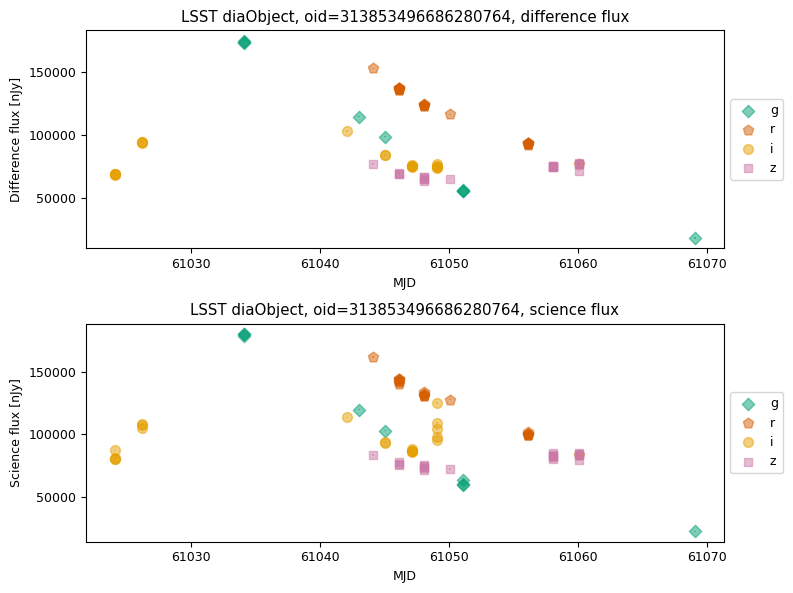

In [17]:
d_objs[sid][oid]['lc_kwargs']['show_forced'] = True

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

We can show these light curves using magnitude units

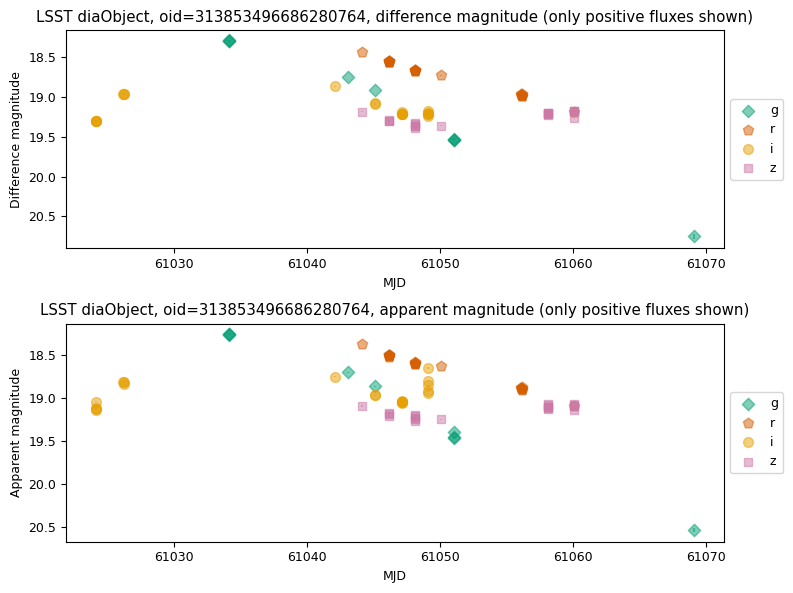

In [18]:
d_objs[sid][oid]['lc_kwargs']['show_flux'] = False
d_objs[sid][oid]['lc_kwargs']['show_forced'] = False

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

We can also show them using absolute magnitudes, assuming the redshift of the tentative host and the Planck 2018 cosmology

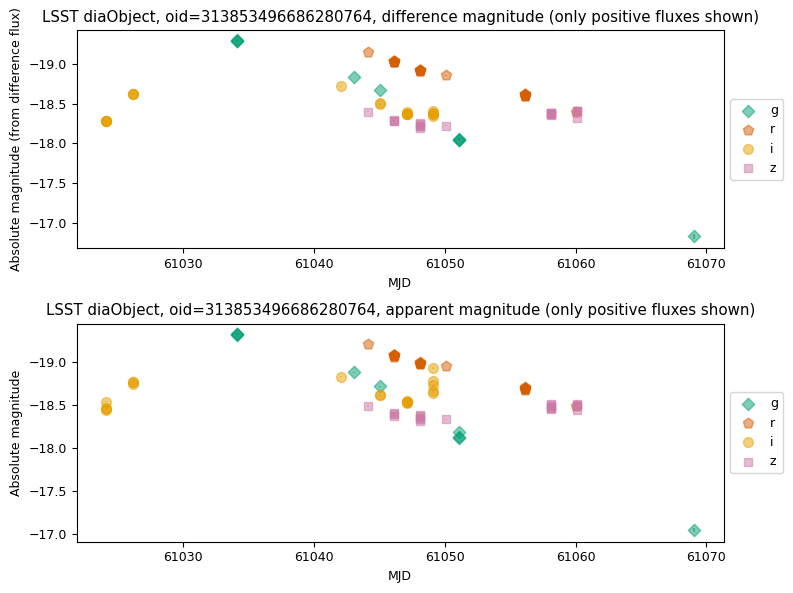

In [19]:
d_objs[sid][oid]['lc_kwargs']['show_absolute_mag'] = True
d_objs[sid][oid]['lc_kwargs']['z_obj'] = z_obj
d_objs[sid][oid]['lc_kwargs']['cosmo'] = Planck18

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

#### Stamps

We show alert image cutouts for the first 3 detections of this object that triggered alerts. Note that not all stored detections may have triggered an alert, as they may come in an alert as previous detections. The field ```has_stamp``` in our detections dataframe indicates that a given detection triggered an alert, so that we can use it as a mask as

In [20]:
mask = epochs['detections']['has_stamp']
df_dets_this = epochs['detections'][mask].sort_values(by='mjd').iloc[0:3].copy()

cols = ['measurement_id', 'band_name', 'mjd',
        'psfFlux', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr',
        'has_stamp']
display(df_dets_this[cols])

,measurement_id,band_name,mjd,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,has_stamp
oid,,,,,,,,
313853496686280764,313853496686280764,i,61024.131420,69393.810,434.88135,87073.445,451.60373,True
313853496686280764,313853498027933784,i,61024.138132,68777.630,369.12128,80362.010,372.00574,True
313853496686280764,313853498568474633,i,61024.140180,68613.234,369.33966,79989.170,374.35675,True


We retrieve the stamps, obtaining the main fields: Science, Template and Difference

In [21]:
for i, row in df_dets_this.iterrows():
    params = {
        'survey': 'lsst',
        'oid': i,
        'measurement_id': row['measurement_id'],
    }
    df_stamps = alerce_client.plot_stamps(**params)

We show the same stamps, but using a custom function defined in ```lib_multisurvey```. This requires querying the stamps using the client function ```multisurvey_get_stamps```, that also retrieves the stamps headers

In [22]:
import alerce_mappings as am

In [23]:
fontsize = 8

In [24]:
def set_title(oid=None, sid=None, row=None):
    col_flux = 'psfFlux'
    col_flux_err = 'psfFluxErr'

    title = am.sid_num2str[sid] + ', oid=' + str(oid) + ', ' \
            + 'measurement_id=' + str(row['measurement_id']) + '\n' \
            + 'band=' + row['band_name'] + ', ' \
            + 'mjd=%.4f' % row['mjd'] + ', ' \
            + 'S/N=%.2f' % row['snr'] + ', ' \
            + 'psfFlux=%.f' % row[col_flux] + '+-' \
            + '%.f uJy' % row[col_flux_err]

    return title

In [25]:
df_stamps = ms.query_stamps(df_objs=df_dets_this, survey='lsst', sid=1)
print(df_stamps.columns)

Index(['measurement_id', 'flux_Science_data', 'flux_Science_header',
       'flux_Template_data', 'flux_Template_header', 'flux_Difference_data',
       'flux_Difference_header'],
      dtype='object')


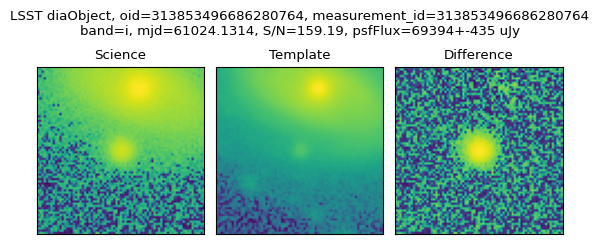

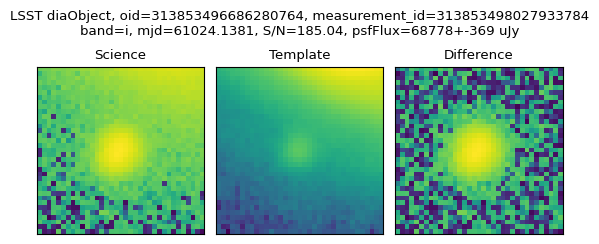

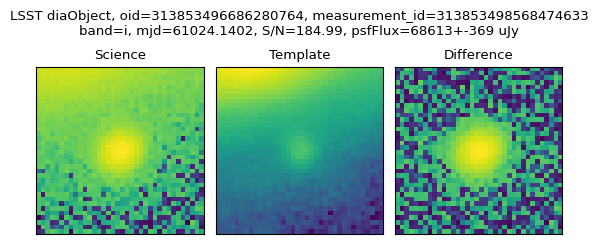

In [26]:
for i, row_this in df_dets_this.iterrows():
    #display(pd.DataFrame(row_this).T)
    
    mask = df_stamps.loc[[i]]['measurement_id'] == row_this['measurement_id']
    obj = df_stamps.loc[[i]][mask]
    #display(obj)
    
    for i, row in obj.iterrows():
        title = set_title(oid=i, sid=sid, row=row_this)
        ms.plot_stamps(row, title=title, fontsize=fontsize)

Note that LSST images are not always aligned. We use the header WCS to show stamps including equatorial coordinates. We continue this section showing only stamps for the first detection

In [27]:
df_dets_this = df_dets_this[~df_dets_this.index.duplicated(keep='first')].copy()
display(df_dets_this)

,band,mjd,survey_id,ra,dec,measurement_id,parentDiaSourceId,diaObjectId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_flag_edge,psfFlux_flag_noGoodPixels,scienceFlux,scienceFluxErr,has_stamp,visit,detector,ssObjectId,raErr,decErr,ra_dec_Cov,x,xErr,y,yErr,centroid_flag,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,isNegative,snr,psfLnL,psfChi2,psfNdata,trailFlux,trailFluxErr,trailRa,trailRaErr,trailDec,trailDecErr,trailLength,trailLengthErr,trailAngle,trailAngleErr,trailChi2,trailNdata,trail_flag_edge,dipoleMeanFlux,dipoleMeanFluxErr,dipoleFluxDiff,dipoleFluxDiffErr,dipoleLength,dipoleAngle,dipoleChi2,dipoleNdata,forced_PsfFlux_flag,forced_PsfFlux_flag_edge,forced_PsfFlux_flag_noGoodPixels,templateFlux,templateFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,isDipole,dipoleFitAttempted,timeProcessedMjdTai,timeWithdrawnMjdTai,bboxSize,pixelFlags,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_nodata,pixelFlags_nodataCenter,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_offimage,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail,band_name
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
313853496686280764,3,61024.13142,lsst,9.352321,-42.46275,313853496686280764,0,313853496686280764,69393.81,434.88135,0,0,0,87073.445,451.60373,True,2025121400756,176,0,0.000002,0.000002,5.811162e-14,2549.338,0.035994,3547.1082,0.033921,False,70119.43,652.0254,False,False,False,159.18846,None,1670.2264,1681,68759.984,0.476512,9.352321,None,-42.46275,None,0.585214,None,-84.04936,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,14675.602,9.231125,0.457387,0.431268,0.006412,0.462593,0.435522,-0.000829,False,False,False,False,0.001248,0.999998,False,False,61081.910089,None,75,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i


We show the header for the Science cutout

In [28]:
row_this = df_stamps.iloc[0].copy()
display(row_this['flux_Science_header'])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   75                                                  
NAXIS2  =                   75                                                  
EXTEND  =                    T                                                  
CUTMINX =                 2511                                                  
CUTMINY =                 3509                                                  
ROTPA   =     352.530439684183 / Pos angle in deg of focal plane +Y wrt North   
BUNIT   = 'nJy     '                                                            
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      38.337831164878 / Pixel coordinate of reference point            
CRPIX2  =      38.1082627054

Having the header data, we can plot stamps including WCS axes

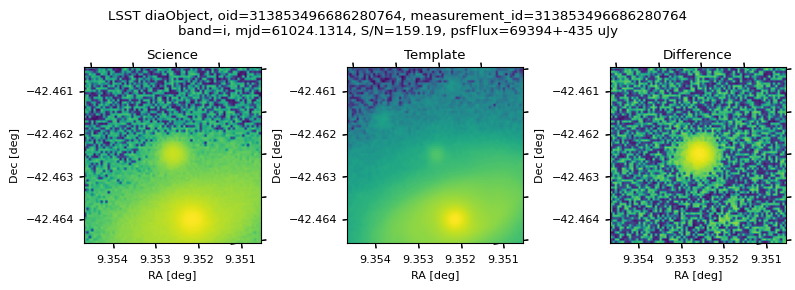

In [29]:
for j, row_this in df_dets_this.iterrows():
    mask = df_stamps.loc[[j]]['measurement_id'] == row_this['measurement_id']
    obj = df_stamps.loc[[j]][mask]
    
    for i, row in obj.iterrows():
        title = set_title(oid=i, sid=sid, row=row_this)
        ms.plot_stamps(row, title=title, fontsize=fontsize,
                       use_wcs=True, figsize=[8, 8], title_offset=0.68)

The client function ```multisurvey_get_stamps``` also allows to retrieve additional planes included in LSST stamps, i.e. variance and mask (actually PSF; we will change this name in a future version). We can compute the image shape of each plane and cutout type

In [30]:
include_variance_and_mask = True

df_stamps = ms.query_stamps(
    df_objs=df_dets_this,
    sid=sid,
    include_variance_and_mask=include_variance_and_mask
)
print(df_stamps.columns)

Index(['measurement_id', 'flux_Science_data', 'flux_Science_header',
       'flux_Template_data', 'flux_Template_header', 'flux_Difference_data',
       'flux_Difference_header', 'variance_Science_data',
       'variance_Science_header', 'variance_Template_data',
       'variance_Template_header', 'variance_Difference_data',
       'variance_Difference_header', 'mask_Science_data',
       'mask_Science_header', 'mask_Template_data', 'mask_Template_header',
       'mask_Difference_data', 'mask_Difference_header'],
      dtype='object')


In [31]:
cols = []
for plane in am.image_planes:
    cols += [plane + '_' + x + '_data' for x in am.image_subtypes]
#print(cols)

for col in cols:
    df_stamps[col.replace('data', 'shape')] = [x.shape for x in df_stamps[col]]
display(df_stamps[['measurement_id'] + [x.replace('data', 'shape') for x in cols]])

,measurement_id,flux_Science_shape,flux_Template_shape,flux_Difference_shape,variance_Science_shape,variance_Template_shape,variance_Difference_shape,mask_Science_shape,mask_Template_shape,mask_Difference_shape
oid,,,,,,,,,,
313853496686280764,313853496686280764,"(75, 75)","(75, 75)","(75, 75)","(75, 75)","(75, 75)","(75, 75)","(41, 41)","(43, 43)","(41, 41)"


We plot all planes for the stamps shown above

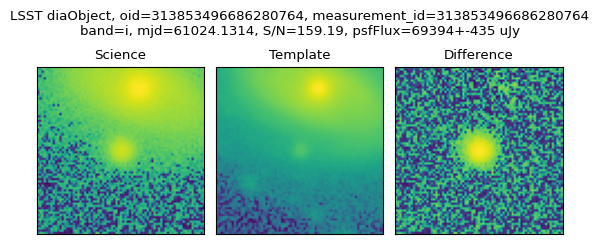

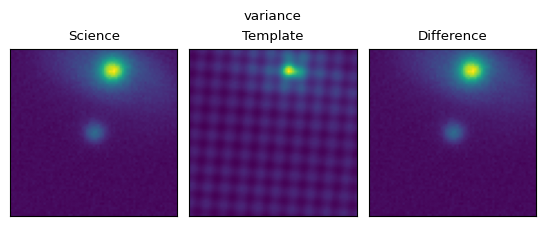

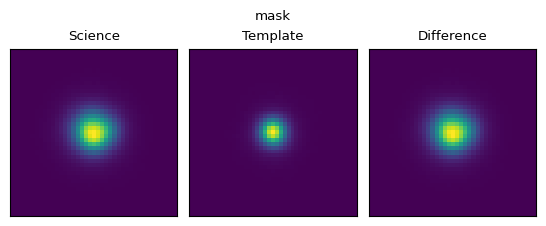

In [32]:
for j, row_this in df_dets_this.iterrows():
    #display(pd.DataFrame(row_this).T)
    
    mask = df_stamps.loc[[j]]['measurement_id'] == row_this['measurement_id']
    obj = df_stamps.loc[[j]][mask]
    #display(obj)
    
    for i, row in obj.iterrows():
        #display(row)
        title = set_title(oid=i, sid=sid, row=row_this)
        for plane in am.image_planes:
            title_aux = title if plane == 'flux' else plane
            title_offset = 0.72 if plane == 'flux' else 0.7
            ms.plot_stamps(row, plane=plane, title=title_aux,
                           fontsize=fontsize, title_offset=title_offset)

### Cone search

Let us say we want to know if the known RRLab star SSS_J004408.1-432806 has triggered Rubin alerts. This star has equatorial coordinates (11.03301, -43.46871) deg and a period of 0.546472 d in VSX (see https://vsx.aavso.org/index.php?view=detail.top&oid=479455). We use a cone search with a small radius (e.g. 1.5 arcsec)

In [33]:
ra = 11.03301
dec = -43.46871
period = 0.546472
radius = 1.5

Note that you need to provide object coordinates in equatorial system in deg, and search radius in arcsec

In [34]:
df_obj = alerce_client.query_objects(
    survey='lsst',
    ra=ra,
    dec=dec,
    radius=radius
)
df_obj

,oid,tid,sid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,deltamjd,n_det,n_forced,n_non_det,stellar,class_name,classifier_name,classfier_version,probability,ranking
0,313629129709715483,1,1,11.033297,-43.468727,4.283685e-07,4.236282e-07,60973.170251,61060.081744,86.911493,39,0,0,None,VS,stamp_classifier_rubin,None,0.984722,1


Now that we know the object identifier in LSST (and its ```sid```) we can query other data as before. In particular, we obtain its light curve and show it also as a folded light curve using the known period

In [35]:
oid = df_obj.iloc[0]['oid']
sid = df_obj.iloc[0]['sid']

In [36]:
df_dets = alerce_client.query_detections(oid, survey='lsst',
                                         format='pandas')
display(df_dets)

,band,mjd,survey_id,ra,dec,oid,measurement_id,parentDiaSourceId,diaObjectId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_flag_edge,psfFlux_flag_noGoodPixels,scienceFlux,scienceFluxErr,has_stamp,visit,detector,ssObjectId,raErr,decErr,ra_dec_Cov,x,xErr,y,yErr,centroid_flag,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,isNegative,snr,psfLnL,psfChi2,psfNdata,trailFlux,trailFluxErr,trailRa,trailRaErr,trailDec,trailDecErr,trailLength,trailLengthErr,trailAngle,trailAngleErr,trailChi2,trailNdata,trail_flag_edge,dipoleMeanFlux,dipoleMeanFluxErr,dipoleFluxDiff,dipoleFluxDiffErr,dipoleLength,dipoleAngle,dipoleChi2,dipoleNdata,forced_PsfFlux_flag,forced_PsfFlux_flag_edge,forced_PsfFlux_flag_noGoodPixels,templateFlux,templateFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,isDipole,dipoleFitAttempted,timeProcessedMjdTai,timeWithdrawnMjdTai,bboxSize,pixelFlags,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_nodata,pixelFlags_nodataCenter,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_offimage,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail,band_name
0,3,60973.170251,lsst,11.033278,-43.468735,313629129709715483,313629129709715483,0,313629129709715483,33248.160,519.14417,0,0,0,134026.530,550.59240,True,2025102400260,114,0,0.000005,0.000006,-3.776119e-13,3027.14720,0.099165,2078.81800,0.086456,False,33205.824,682.27300,False,False,False,63.852493,None,1558.3109,1681,32727.422,0.901845,11.033278,None,-43.468735,None,0.935255,None,163.976820,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,99079.305,6.257832,0.552269,0.483983,-0.016753,0.561423,0.495099,-0.022474,False,False,False,False,0.004855,0.953479,False,False,61081.913394,None,46,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,i
1,1,60985.230983,lsst,11.033313,-43.468695,313629129709715483,313681911507582991,0,313629129709715483,37216.777,1060.50040,0,0,0,119017.060,1155.06070,True,2025110500299,124,0,0.000014,0.000016,1.717819e-11,3998.23360,0.245487,1315.31930,0.292089,False,36573.418,1273.32650,False,False,False,35.011997,None,1683.1191,1681,42238.754,0.554851,11.033313,None,-43.468696,None,1.825352,None,12.985518,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,79312.230,4.522082,1.101247,1.398299,0.002013,1.026416,1.094702,-0.004008,False,False,False,False,0.570685,0.601747,False,False,61081.979479,None,62,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,g
2,1,60985.231420,lsst,11.033364,-43.468729,313629129709715483,313681911641800716,0,313629129709715483,36954.535,955.31450,0,0,0,115490.460,1005.50840,True,2025110500300,124,0,0.000011,0.000012,7.162491e-12,3999.88160,0.191681,1314.09200,0.217387,False,36129.395,1185.94740,False,False,False,38.629536,None,1676.4487,1681,38975.496,5.600237,11.033369,None,-43.468725,None,1.177886,None,-156.997010,None,None,0,False,None,None,None,None,None,None,None,0,False,False,False,77631.766,3.691063,0.856921,0.970321,-0.019819,0.838971,0.968011,0.037384,False,False,False,False,0.002841,0.991222,False,False,61081.944779,None,53,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,g
3,1,60991.237160,lsst,11.033339,-43.468733,313629129709715483,313708285430071331,0,313629129709715483,37629.850,317.62115,0,0,0,113694.230,324.51680,True,2025111100192,133,0,0.000002,0.000002,-2.287745e-13,3358.41330,0.040580,2181.60620,0.038183,False,38099.770,384.06613,False,False,False,119.551346,None,1878.9166,1681,35855.695,0.028093,11.03333

In [37]:
df_forced = alerce_client.query_forced_photometry(oid, survey='lsst',
                                                  format='pandas')
display(df_forced)

""


In [38]:
lc_params = {
    'use_mag': False,
    'use_flux': True,
    'show_yr': False,
    'figwidth': 8,
    'pheight': 3,
    'fontsize': 9,
    'alpha': 0.5,
}

In [39]:
df_dets.set_index('oid', inplace=True)
if len(df_forced) > 0:
    df_forced.set_index('oid', inplace=True)

epochs = {
    'detections': df_dets,
    'forced_photometry': df_forced,

}
d_objs = ms.group_data_sid_oid(
    sid=sid,
    oid=oid,
    df_dets=epochs['detections'].copy(),
    df_forced=epochs['forced_photometry'].copy() \
        if oid in epochs['forced_photometry'].index else pd.DataFrame(),
        lc_kwargs=ms.init_lc_kwargs()
    )

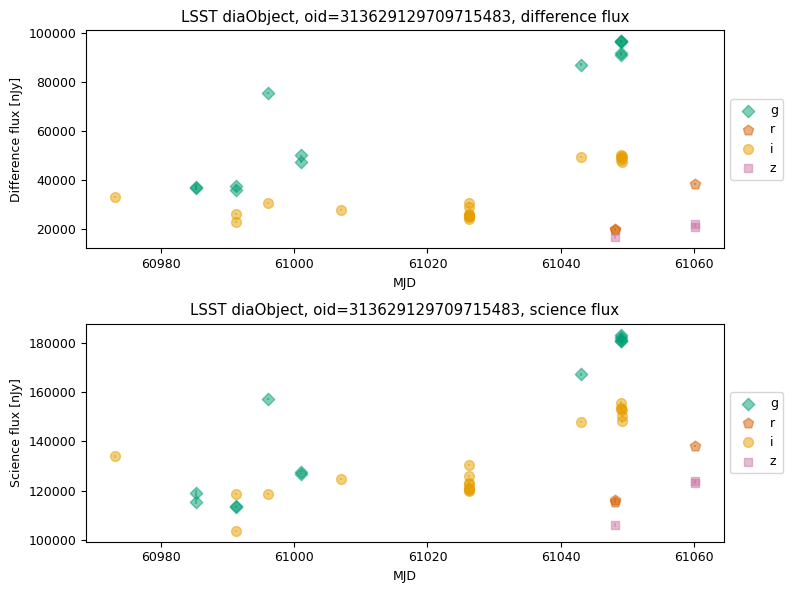

In [40]:
d_objs[sid][oid]['lc_kwargs']['show_forced'] = True

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

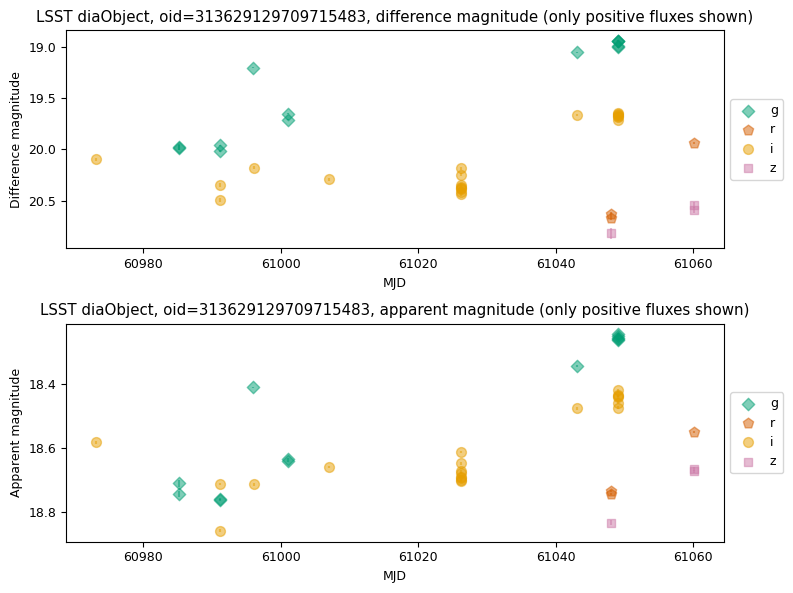

In [41]:
d_objs[sid][oid]['lc_kwargs']['show_flux'] = False
d_objs[sid][oid]['lc_kwargs']['show_forced'] = False

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

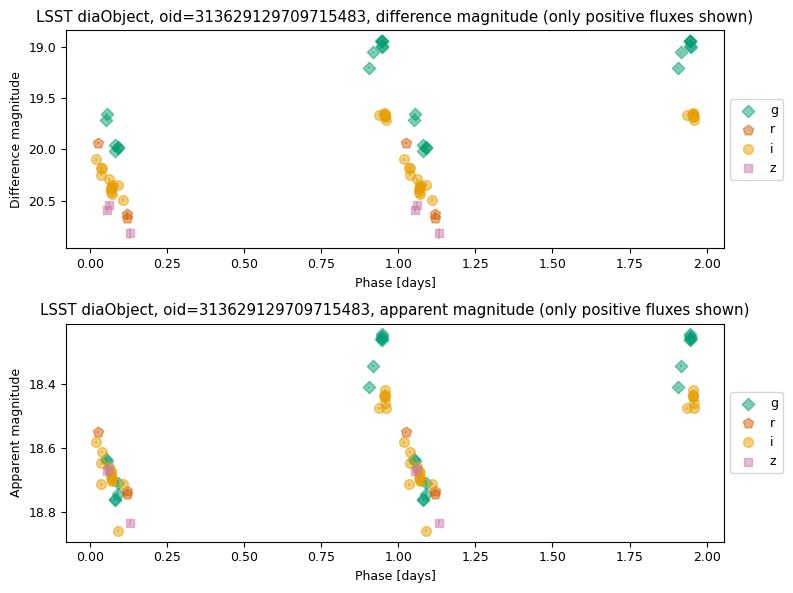

In [42]:
d_objs[sid][oid]['lc_kwargs']['show_folded'] = True
d_objs[sid][oid]['lc_kwargs']['folded_period'] = period

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

## Querying samples of objects

The ALeRCE pipeline computes probabilities for different classifiers. At this time, we classify LSST objects using the ALeRCE stamp classifier, which is a deep learning classifier based on each object's first alert image cutouts (manuscript in preparation; see [Carrasco-Davis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162..231C/abstract) for a similar version using the ZTF public alert stream). This classifier taxonomy includes five classes, and is used to pre-select transient candidates (e.g. supernovae, tidal disruption events) early after their first light.

We search for 15 objects that had their first detection between Nov 1 2025 and Feb 1 2026, their last detection after Feb 5 2026, have more than 50 detections, and have the highest probability of being a supernova (SN) according to this classifier, as

In [43]:
firstmjd_min = Time('2025-11-01T00:00:00', format='isot', scale='utc').mjd
firstmjd_max = Time('2026-02-01T00:00:00', format='isot', scale='utc').mjd
print(firstmjd_min, firstmjd_max)

lastmjd_min = Time('2026-02-05T00:00:00', format='isot', scale='utc').mjd
print(lastmjd_min)

df_objs = alerce_client.query_objects(
    survey='lsst',
    classifier='stamp_classifier_rubin',
    class_name='SN',
    n_det=[50, None],
    firstmjd=[firstmjd_min, firstmjd_max],
    lastmjd=[lastmjd_min, None],
    page_size=15,
    order_by='probability',
    order_mode='DESC',
    format='pandas'
)
display(df_objs)

60980.0 61072.0
61076.0


,oid,tid,sid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,deltamjd,n_det,n_forced,n_non_det,stellar,class_name,classifier_name,classfier_version,probability,ranking
0,313893023122980956,1,1,62.081009,-46.931759,2.830006e-07,2.768487e-07,61033.284793,61095.094861,61.810069,150,184,0,None,SN,stamp_classifier_rubin,None,0.995795,1
1,313897384094990464,1,1,62.579228,-47.370058,2.821594e-07,2.775291e-07,61034.161767,61095.094861,60.933095,98,181,0,None,SN,stamp_classifier_rubin,None,0.994967,1
2,313893022985093146,1,1,59.281330,-48.804297,3.520819e-07,3.461509e-07,61033.284331,61095.092636,61.808305,70,174,0,None,SN,stamp_classifier_rubin,None,0.988114,1
3,313765480585756826,1,1,59.231641,-47.930115,2.114016e-07,2.054142e-07,61004.301777,61095.094433,90.792656,94,175,0,None,SN,stamp_classifier_rubin,None,0.986866,1
4,313853517427113991,1,1,150.941345,2.854716,5.305153e-07,5.407373e-07,61024.245933,61095.164111,70.918178,240,399,0,None,SN,stamp_classifier_rubin,None,0.985246,1
5,313761042364104803,1,1,64.421987,-46.929332,2.053707e-07,2.013206e-07,61003.324393,61095.090467,91.766073,128,166,0,None,SN,stamp_classifier_rubin,None,0.984061,1
6,313853517407191050,1,1,150.589613,3.575726,9.616933e-07,9.815641e-07,61024.245933,61095.163030,70.917097,97,371,0,None,SN,stamp_classifier_rubin,None,0.983487,1
7,314051320305156133,1,1,60.377671,-48.821995,8.467094e-08,8.307325e-08,61069.077763,61095.094433,26.016670,208,209,0,None,SN,stamp_classifier_rubin,None,0.981536,1
8,313897384088699002,1,1,62.485058,-46.648884,4.980077e-07,5.166626e-07,61034.161767,61095.091331,60.929565,51,176,0,None,SN,stamp_classifier_rubin,None,0.964530,1
9,313941451367514113,1,1,65.277690,-46.709812,1.904734e-07,1.879436e-07,61044.144509,61095.088734,50.944225,62,75,0,None,SN,stamp_classifier_rubin,None,0.958628,1


### Generate an ALeRCE LSST Explorer link for these objects (maximum 200 objects accepted by the interface)

In [44]:
def print_link(index=None):
    if len(index) == 1:
        expr = 'https://lsst.alerce.online/object/' + index[0] \
               + '?survey=lsst'
    else:
        expr1 = 'https://lsst.alerce.online/?oid='
        expr2 = ','.join(list(index))
        expr3 = '&survey=lsst'
        expr = expr1 + expr2 + expr3
    
    display(HTML("<a href='%s' target=\"_blank\"> %s <a>" % (expr, expr)))


In [45]:
print_link(index=df_objs['oid'].astype(str))

### Object lists

Note that we can also search by a list of known object identifiers

In [46]:
oids = [
    313853517444939794,
    313853517424492585,
    313853517419249797
]

In [47]:
df_objs = alerce_client.query_objects(
    oid=oids,
    survey='lsst',
    format='pandas'
)
display(df_objs)

,oid,tid,sid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,deltamjd,n_det,n_forced,n_non_det,stellar,class_name,classifier_name,classfier_version,probability,ranking
0,313853517424492585,1,1,149.698756,2.441227,4.124291e-07,4.272506e-07,61024.245933,61095.164111,70.918178,560,417,0,None,AGN,stamp_classifier_rubin,None,0.884223,1
1,313853517419249797,1,1,149.444065,2.548378,1.657488e-07,1.738971e-07,61024.245933,61095.221243,70.975310,559,409,0,None,AGN,stamp_classifier_rubin,None,0.870963,1
2,313853517444939794,1,1,149.738952,2.220690,2.633515e-07,2.711467e-07,61024.245933,61095.221243,70.975310,574,395,0,None,AGN,stamp_classifier_rubin,None,0.646737,1


In [48]:
print_link(index=df_objs['oid'].astype(str))